# **Part II: Exploratory analysis of MRI data** 
Your task in Part II is to explore the 3D MRI scans, get familiar with the NIfTI-1 neuroimaging file format, and apply signal processing methods to the MRI data. You need to mount your Google Drive to access the MRI data (like in Part I).

In [538]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from nilearn import plotting
import nilearn
import nibabel

#### Import MRI data

In [539]:
## Choose patient ID number 
subject = 'sub-OASIS10003'
#subject = 'sub-OASIS10001'
#subject = 'sub-OASIS10184'
#subject = 'sub-OASIS10322'
#subject = 'sub-OASIS10440'
patients = ['sub-OASIS10003','sub-OASIS10001','sub-OASIS10184','sub-OASIS10322','sub-OASIS10440']

# Import data from compressed NIfTI-1 file format using NiBabel
raw_data = nibabel.load('../data/raw/' + subject + '.nii.gz')

# Image header
header = raw_data.header 

# Image tensor (Numpy format)
image_data = raw_data.get_fdata()

# Affine spatial transform
affine_spatial_transform = raw_data.affine

In [540]:
# Analyze the header and answer the questions (MRI image shape, voxel size, image data type)
# Look up information about NIfTI1 format headers in the NiBabel documentation 
print(header)
print(header.get_zooms())
print(type(raw_data))
list(raw_data.file_map)

raw_data.file_map['image'].filename

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 256 256 160   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  0.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FreeSurfer May 14 2013'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.5
quatern_c       : 0.5
quatern_d       : 0.5
qoffset_x       : 80.0
qoffset_y       : -128.0
qoffset_z       : -128.0
srow_x          : [

'../data/raw/sub-OASIS10003.nii.gz'

In [541]:
#print(header.get_data_dtype())


#### Data slicing and plotting

In [542]:
# Complete the function hereunder
def show_MRI_slices(slices):
    """ Display a row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(10,5))
    fig.tight_layout()
    for i, slice in enumerate(slices):
        axes[i].imshow(slice)

def loadPatient(patientID):
    rawData = nibabel.load('../data/raw/' + patientID + '.nii.gz')
    return rawData

def slicePatient(patientData):
    sliceYZ = patientData[127, :, :]
    sliceXZ = patientData[:, 127, :]
    sliceXY = patientData[:, :, 80]
    return sliceXY, sliceYZ, sliceXZ

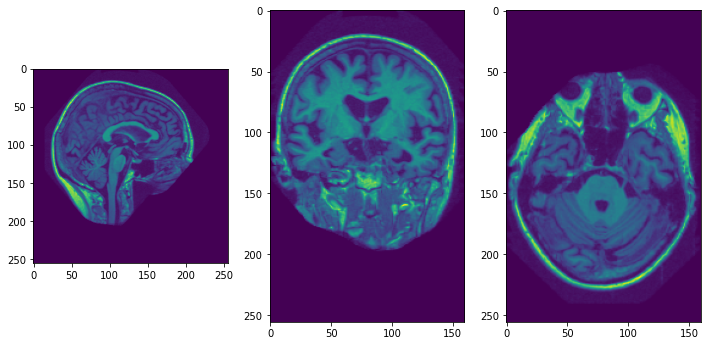

<Figure size 432x288 with 0 Axes>

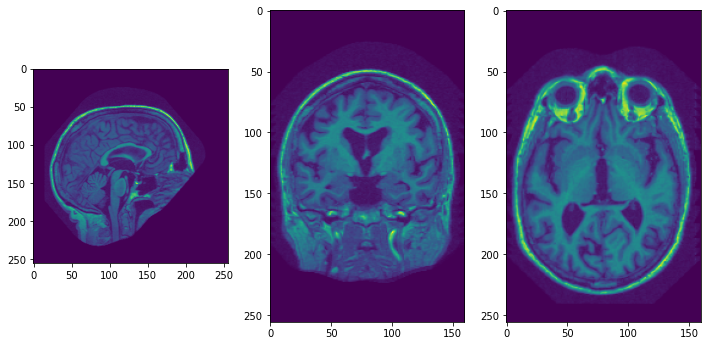

<Figure size 432x288 with 0 Axes>

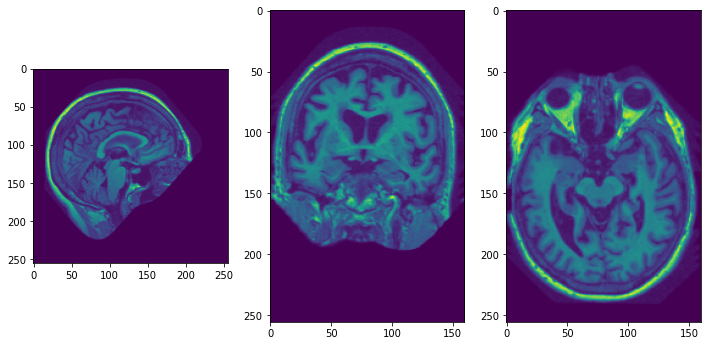

<Figure size 432x288 with 0 Axes>

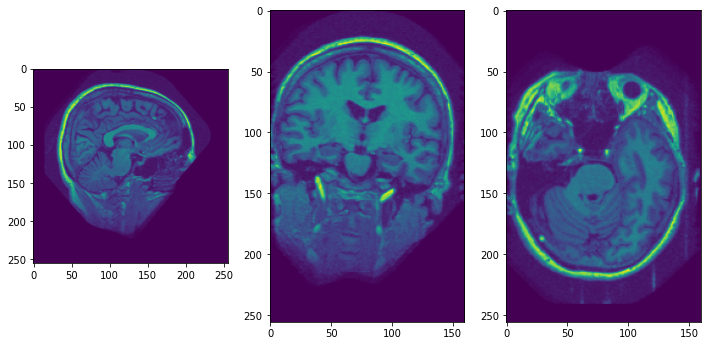

<Figure size 432x288 with 0 Axes>

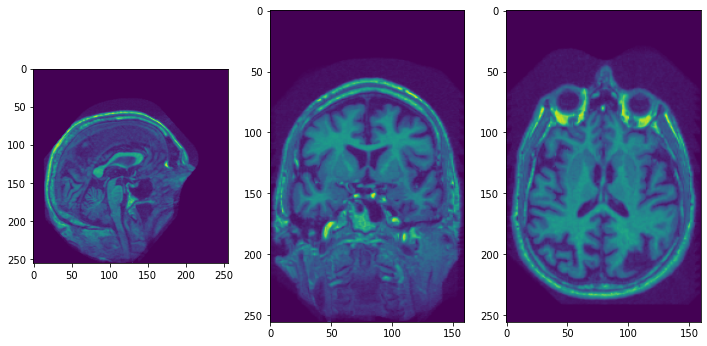

<Figure size 432x288 with 0 Axes>

In [543]:
# Replace the question marks, and uncomment the following lines of code
patients = ['sub-OASIS10003','sub-OASIS10001','sub-OASIS10184','sub-OASIS10322','sub-OASIS10440']

for patient in patients:
    patientData = loadPatient(patient)
    patientData = patientData.get_fdata()
    sliceXY, sliceYZ, sliceXZ = slicePatient(patientData)
    show_MRI_slices([ndimage.rotate(sliceXY,90), ndimage.rotate(sliceYZ, 180), ndimage.rotate(sliceXZ, 180)])
    plt.show()
    plt.savefig('../graphics/part2/'+patient+'.png')

#slices = slicePatient(patientData)
#show_MRI_slices([ndimage.rotate(sliceXY,90), ndimage.rotate(sliceYZ, 180), ndimage.rotate(sliceXZ, 180)])


#### Background removal

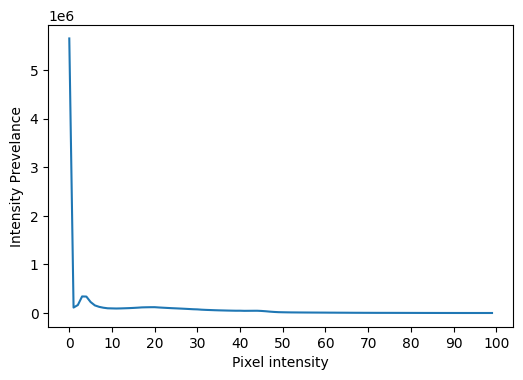

In [544]:
num_bins = 100
plt.figure(dpi=100)
plt.plot(ndimage.histogram(patientData, min=0, max=np.max(patientData), bins=num_bins))
plt.xticks(np.arange(0, num_bins+1, 10))
plt.xlabel("Pixel intensity")
plt.ylabel("Intensity Prevelance")
plt.show()


In the histogram above, there is a large peak close to zero because the voxels making up the large empty space (air) surrounding the head have values at or close to zero. We will now use the image histogram to create a mask that isolates a particular range of intensity values in the image, while setting all other intensity values to zero. Although it is a very simple approach, it can be useful for background removal (and also for segmenting the grey or white matter).

We start by manually defining the range of intensity values that we consider background (the window containing the small peak). Based on the histogram above, we will choose a range from bins 1 to 5. Since the x axis of the histogram is bin numbers, rather than intensity values, we need to determine what intensities corresponding to bins 1 to 5. Since we know the histogram divided the range from 0 to the maximum intensity value in the image, into 100 bins, we can divide the max intensity value by 100 to get the width of each bin, then multiply by the values we observed on the x axis.

Next we create two binary masks of the image: one mask for the voxels whose intensity is greater than background_min and the other for the voxels whose intensity value is less than background_max. We combine the two masks by adding them: any voxel that is in the range between background_min and background_max will have a value of 2. The resulting background_mask selects only voxels belonging to the background area that we want to remove from the image.

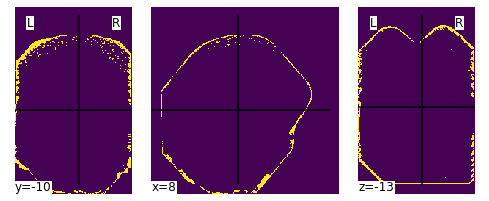

In [545]:
# Basic background mask
patientData = loadPatient(patients[4])
patientAffine = patientData.affine
patientData = patientData.get_fdata()

background_min = ((np.max(patientData)) / num_bins) * 0
background_max = ((np.max(patientData)) / num_bins) * 3
background_mask = np.where(patientData > background_min, 1, 0) + np.where(patientData < background_max, 1, 0)
background_mask = np.where(background_mask == 2, 1, 0)

# Use the affine spatial transform to turn the binary mask into a NIfTI file
#background_mask_nifti = nibabel.Nifti1Image(background_mask, affine_spatial_transform)
background_mask_nifti = nibabel.Nifti1Image(background_mask, patientAffine)

# Plot the result using Nilearn's plotting function (or a Matplotlib alternative)
plotting.plot_img(background_mask_nifti)
plt.show()

In [546]:
# Apply morphological operations to background mask
struct = ndimage.generate_binary_structure(3, 3)
new_background_mask = ndimage.grey_opening(background_mask, structure=struct).astype(patientData.dtype)

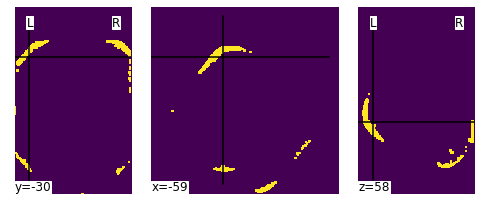

In [547]:
# Plot the new background mask using NiBabel and Nilearn (or use your own slicing and plotting function)
new_background_mask_nifti = nibabel.Nifti1Image(new_background_mask, patientAffine)

plotting.plot_img(new_background_mask_nifti)
plt.show()

In [548]:

#new_background_mask = ndimage.generic_filter(patientData,new_background_mask_smoothed,(1,1,1))

Your task is to improve the new background mask! You could try using the different scipy.ndimage multidimensional image processing functions (e.g. filtering, morphological operations) that are listed here: https://docs.scipy.org/doc/scipy/reference/ndimage.html. Remember that the opening of an image by a structuring element is the dilation of the erosion of the image by the structuring element; and the closing of an image by a structuring element is the erosion of the dilation of the image by the structuring element.You could also try smoothing the background mask before selecting a window of intensity values using a Gaussian filter with Nilearn: https://nilearn.github.io/modules/generated/nilearn.image.smooth_img.html. 

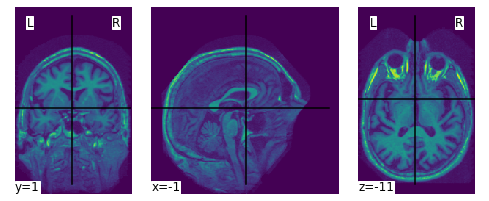

In [549]:
# Set background voxels to zero 
image_data_no_background = patientData
image_data_no_background[new_background_mask==True] = 0
image_no_background_nifti = nibabel.Nifti1Image(image_data_no_background, patientAffine)
plotting.plot_img(image_no_background_nifti)
plt.show()

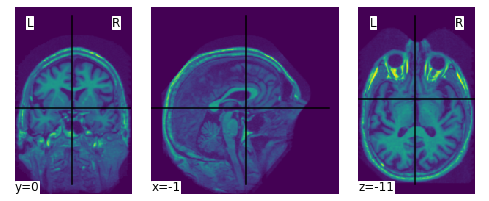

In [550]:
image_no_background_nifti = nilearn.image.smooth_img(image_no_background_nifti, "fast") 

plotting.plot_img(image_no_background_nifti)
plt.show()

#### White matter segmentation 
What follows is an example of how basic MRI segmentation can be done after background removal. You do not need to write any code or answer any questions regarding this part here.

Now that we have removed the background from the MRI scan, we can try to make a mask specific to the white matter. We follow the same approach as previously: we start by identifying a range of the histogram that corresponds to the white matter. There is a peak at 10 on the x-axis, which indicates a large number of voxels whose intensity values are similar and relatively high. Given the T1-weighted MRI highlight white matter, it is fair to assume that a window from 9 to 10 corresponds to the white matter. We make a mask for these voxels, but we notice that some voxels corresponding to the skull are also included. So we use morphological operations to improve the white matter mask. 

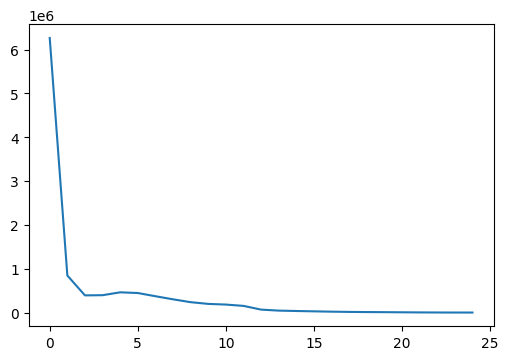

In [551]:
num_bins = 25
plt.figure(dpi=100)
plt.plot(ndimage.histogram(image_data_no_background, min=0, max=np.max(image_data_no_background), bins=num_bins))
plt.xticks(np.arange(0, num_bins+1, 5))
plt.show()

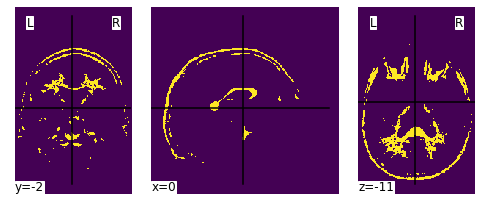

In [552]:
image_data_no_background = patientData
white_matter_min = ((np.max(image_data_no_background)) / num_bins) *11 
white_matter_max = ((np.max(image_data_no_background)) / num_bins) * 25
white_matter_mask = np.where(image_data_no_background > white_matter_min, 1, 0) + np.where(image_data_no_background < white_matter_max, 1, 0)

white_matter_mask_nifti = nibabel.Nifti1Image(white_matter_mask, patientAffine)
plotting.plot_img(white_matter_mask_nifti)
plt.show()

In [553]:
# Morphological operations
struct_small = ndimage.generate_binary_structure(3, 1)
struct_big = ndimage.generate_binary_structure(3, 6)
new_white_matter_mask = ndimage.grey_erosion(white_matter_mask, structure=struct_small).astype(patientData.dtype)
new_white_matter_mask = ndimage.grey_dilation(new_white_matter_mask, structure=struct_big).astype(patientData.dtype)

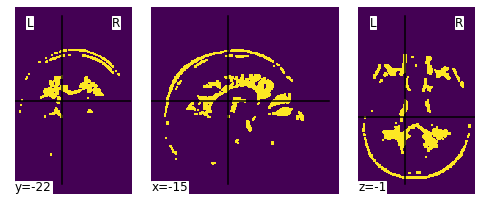

In [554]:
new_white_matter_mask_nifti = nibabel.Nifti1Image(new_white_matter_mask, patientAffine)
plotting.plot_img(new_white_matter_mask_nifti)
plt.show()

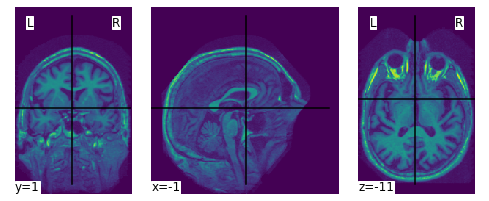

In [555]:
# New white matter mask
image_data_no_background[new_white_matter_mask==False] = 0
image_data_no_skull = nibabel.Nifti1Image(image_data_no_background, patientAffine)
plotting.plot_img(image_data_no_skull)
plt.show()